###version information
##Python 2.7.13
##Anaconda 4.3.1 (64-bit)
##ipython 5.1.0
##jupyter 4.4.0
##plotly 3.4.1
##pandas 0.23.4

In [1]:
from pyspark.ml.regression import LinearRegression
import plotly
import plotly.plotly as py
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from numpy import array
import numpy as np
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import when, col, mean, avg, lit

conf = SparkConf().setAppName('Group10_YelpDataset_V1.0')
sqlContext = SQLContext(sc)
sc

In [2]:
path = "/user/cloudera/data/yelp_academic_dataset_business.json"
businessJson = sqlContext.read.json(path)
businessJson.registerTempTable("businessTable")

In [3]:
cityPhoenix = sqlContext.sql("SELECT * FROM businessTable where city in ('Phx', 'Phoenix Valley', 'Pheonix', 'Pheonix AZ', 'Phoenix' ) and state = 'AZ' and categories like '%Restaurant%'")
cityPhoenix = cityPhoenix.withColumn("city", when(cityPhoenix["city"] == 'Phoenix Valley' , 'Phoenix').otherwise(cityPhoenix["city"]))
cityPhoenix = cityPhoenix.withColumn("city", when(cityPhoenix["city"] == 'Phx' , 'Phoenix').otherwise(cityPhoenix["city"]))
cityPhoenix = cityPhoenix.withColumn("city", when(cityPhoenix["city"] == 'Pheonix' , 'Phoenix').otherwise(cityPhoenix["city"]))
cityPhoenix = cityPhoenix.withColumn("city", when(cityPhoenix["city"] == 'Pheonix AZ' , 'Phoenix').otherwise(cityPhoenix["city"]))

Lets find out how many records did we get of Phoenix:

In [4]:
cityPhoenix.count()

3817

The Business dataset schema looks like this:

In [5]:
cityPhoenix.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [6]:
cityPhoenix.crosstab('review_count','stars').show()

+------------------+---+---+---+---+---+---+---+---+---+
|review_count_stars|4.5|4.0|3.0|3.5|2.0|2.5|5.0|1.5|1.0|
+------------------+---+---+---+---+---+---+---+---+---+
|               645|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|                69|  1|  1|  4|  3|  0|  1|  0|  0|  0|
|              1036|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|               629|  0|  0|  0|  1|  0|  0|  0|  0|  0|
|              1024|  1|  0|  0|  0|  0|  0|  0|  0|  0|
|               365|  1|  1|  0|  0|  0|  0|  0|  0|  0|
|               138|  1|  1|  1|  0|  0|  0|  0|  0|  0|
|               101|  1|  1|  3|  1|  0|  1|  0|  0|  0|
|               347|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|               333|  0|  0|  0|  2|  0|  0|  0|  0|  0|
|               249|  1|  1|  0|  1|  0|  0|  0|  0|  0|
|               962|  0|  1|  0|  0|  0|  0|  0|  0|  0|
|               234|  0|  1|  0|  1|  0|  0|  0|  0|  0|
|                88|  1|  4|  2|  1|  0|  0|  0|  0|  0|
|               481|  0|  1|  0

Let's plot a histogram to see what ratings are more commonly given to all restaurants of Phoenix.

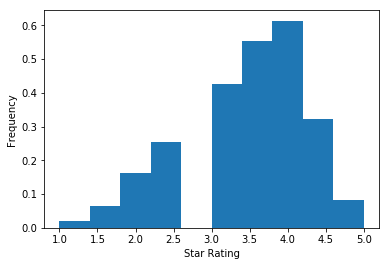

In [7]:
x0 = np.array(cityPhoenix.select('stars').collect())
plt.hist(x0, normed=True)
plt.ylabel('Frequency')
plt.xlabel('Star Rating')
plt.show()

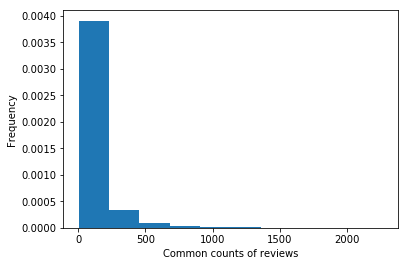

In [8]:
x0 = np.array(cityPhoenix.select('review_count').collect())
plt.hist(x0, normed=True)
plt.ylabel('Frequency')
plt.xlabel('Common counts of reviews')
plt.show()

Now, the number of reviews for each restaurant is different, and so are the star ratings. We cannot rank restaurants simply based on their number of reviews or the stars received. Some restaurants have received 5 stars, even though they have just 1 review and some have received 3 stars with 500 reviews. So, to solve this problem we'll be calculating the ranking as follows [http://www.ebc.cat/2015/01/05/how-to-rank-restaurants/]

bayesian_formula

            S = (w * R) + ((1 - w) * C)
            w = v/(v+m)
   where 
        S = score of the restaurant
        R = average of user ratings for the restaurant
        C = average of user ratings for all restaurants
        w = weight assigned to R and computed as v/(v+m), where v is the number of user ratings for that restaurant, and m is average number of reviews for all restaurants.

Lets calculate rank of each restaurant. Bare with me here. it's going to look messy

In [9]:
cityPhoenix.registerTempTable("phoenixTable")
# df3.show(2)
# +---------------+--------------------+--------------------+--------------------+-------+--------------------+-------+----------+------------+--------------------+------------+-----------+------------+-----+-----+-------+
# |        address|          attributes|         business_id|          categories|   city|               hours|is_open|  latitude|   longitude|                name|neighborhood|postal_code|review_count|stars|state|ranking|
# +---------------+--------------------+--------------------+--------------------+-------+--------------------+-------+----------+------------+--------------------+------------+-----------+------------+-----+-----+-------+
# |2801 N 15th Ave|[null,null,full_b...|_c3ixq9jYKxhLUB0c...|Bars, Sports Bars...|Phoenix|[11:0-23:0,11:0-2...|      1|33.4798071|-112.0911877|Original Hamburge...|            |      85007|         277|  4.0|   AZ|      0|
# |4131 N 83rd Ave|[null,null,null,{...|3ByGQOVgds2YEu6kz...|Nightlife, Bars, ...|Phoenix|                null|      1|33.4952976|-112.2360764|            Rib Shop|            |      85033|           3|  2.5|   AZ|      0|
# +---------------+--------------------+--------------------+--------------------+-------+--------------------+-------+----------+------------+--------------------+------------+-----------+------------+-----+-----+-------+
# only showing top 2 rows
avgOutput = sqlContext.sql("select avg(review_count) as avg_reviews, avg(stars) as avg_stars from phoenixTable")
# avgOutput.show()
# +-----------------+------------------+
# |      avg_reviews|         avg_stars|
# +-----------------+------------------+
# |97.89542143600416|3.4497918834547345|
# +-----------------+------------------+
rank_df = sqlContext.sql("select business_id, name, latitude, longitude, postal_code, review_count, stars, round(((review_count * stars)/(review_count + 97.9)) + ((1 - (review_count/(review_count + 97.9))) * 3.45),2) as ranking from phoenixTable")
# rank_df.show(2)
# +--------------------+--------------------+----------+------------+-----------+------------+-----+-------+
# |         business_id|                name|  latitude|   longitude|postal_code|review_count|stars|ranking|
# +--------------------+--------------------+----------+------------+-----------+------------+-----+-------+
# |_c3ixq9jYKxhLUB0c...|Original Hamburge...|33.4798071|-112.0911877|      85007|         277|  4.0|   3.86|
# |3ByGQOVgds2YEu6kz...|            Rib Shop|33.4952976|-112.2360764|      85033|           3|  2.5|   3.42|
# +--------------------+--------------------+----------+------------+-----------+------------+-----+-------+
# only showing top 2 rows


Now that we have the ranks of the restaurants, lets plot a histogram for the top 10 restaurants based on ranking, and see what stars did they actually receive.

In [10]:
OrderedRestaurants = rank_df.orderBy('ranking', ascending = False)
# OrderedRestaurants.show(7)
# +--------------------+--------------------+-------------+--------------+-----------+------------+-----+-------+
# |         business_id|                name|     latitude|     longitude|postal_code|review_count|stars|ranking|
# +--------------------+--------------------+-------------+--------------+-----------+------------+-----+-------+
# |Xg5qEQiB-7L6kGJ5F...|     Little Miss BBQ|33.4218771341|-111.989344284|      85034|        1746|  5.0|   4.92|
# |9IIhExGT0f6x26hTj...|      Veggie Village|   33.5527294|  -112.0547215|      85020|         213|  5.0|   4.51|
# |VyVIneSU7XAWgMBll...|             Bobby Q|33.5610848047|-112.115746955|      85051|        2267|  4.5|   4.46|
# |OgJ0KxwJcJ9R5bUK0...|         Lux Central|33.5005972575| -112.07423717|      85012|        1923|  4.5|   4.45|
# |9a3DrZvpYxVs3k_qw...|                Cibo|     33.45496|   -112.079908|      85003|        1866|  4.5|   4.45|
# |u-SJ5QUwrNquL9VnX...|     Postino Arcadia|    33.502191|   -111.996292|      85018|        1219|  4.5|   4.42|
# |7m1Oa1VYV98UUuo_6...|Paradise Valley B...|33.6399134922|-111.995703477|      85032|        1131|  4.5|   4.42|
# +--------------------+--------------------+-------------+--------------+-----------+------------+-----+-------+
# only showing top 7 rows
ascendRank = rank_df.orderBy('ranking', 'review_count', ascending = True)
# ascendRank.show(20)
# +--------------------+--------------------+-------------+--------------+-----------+------------+-----+-------+
# |         business_id|                name|     latitude|     longitude|postal_code|review_count|stars|ranking|
# +--------------------+--------------------+-------------+--------------+-----------+------------+-----+-------+
# |bLRjPq9-pAdXirAWW...| Taberna de Tequilla|33.4366741122| -112.00894289|      85034|         173|  2.0|   2.52|
# |R6cWq0FkVfV_Ee-Yt...|        Los Taquitos|33.4338945547|-111.996408471|      85034|         147|  2.0|   2.58|
# |njiPpJhy94Ojq91Be...|       Panda Express|   33.3781912|  -112.1664478|      85042|          78|  1.5|   2.59|
# |V0GHF8CkhOovDeQKC...|                IHOP|     33.47524|     -111.9866|      85008|         117|  2.0|   2.66|
# |_imnJaX4EG_BaoXMC...|          McDonald's|   33.3919383|   -112.072761|      85040|          44|  1.0|   2.69|
# |vyDW7_CHhDUJshMqa...|Steve's Greenhous...|33.4491397838|-112.071727604|      85004|         375|  2.5|    2.7|
# |h4U3h1RbgLvHl0fKS...|         Dairy Queen|   33.6410008|  -112.0051833|      85032|          58|  1.5|   2.72|
# |4x55GDKIP4oHh7H2T...|                IHOP|     33.47544|    -112.22012|      85035|          59|  1.5|   2.72|
# |bJeVUZ8vCVLGYGIaV...|          McDonald's|33.5799409479|-112.013464038|      85028|          52|  1.5|   2.77|
# |YZeUH6zYS0dq5QHLY...|             Hooters|   33.4791778|  -112.2211697|      85035|          87|  2.0|   2.77|
# |wERcL1KznuTgfltSK...|  Zipps Sports Grill|33.5230997097|-112.049281852|      85014|         248|  2.5|   2.77|
# |YlwJYpBWa-oL0byTV...|            The Park|    33.447238|   -112.071084|      85004|         250|  2.5|   2.77|

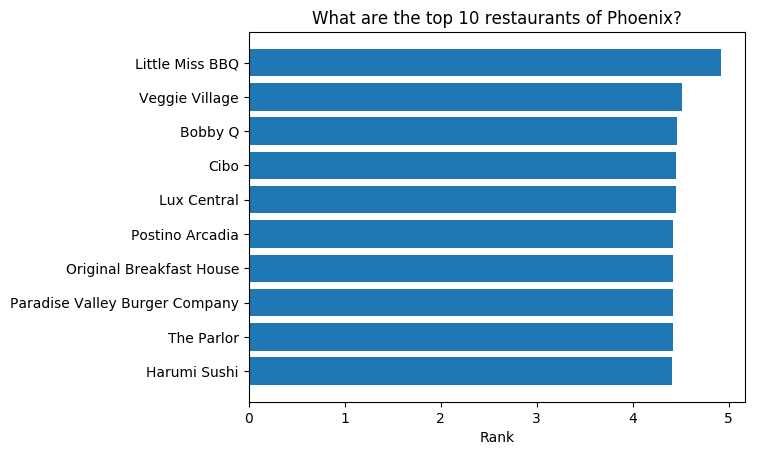

In [11]:
plt.rcdefaults()
fig, ax = plt.subplots()

arr = []
x = np.array(OrderedRestaurants.select('name').take(10))
for i in x:
    for j in i:
        arr.append(str(j))
restaurants = np.array(arr)

y_pos = np.arange(10)
performance = np.array(OrderedRestaurants.select('ranking').take(10))

ax.barh(y_pos, performance)
ax.set_yticks(y_pos)
ax.set_yticklabels(restaurants)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rank')
ax.set_title('What are the top 10 restaurants of Phoenix?')

plt.show()

How many reviews did these top 10 restaurants have?

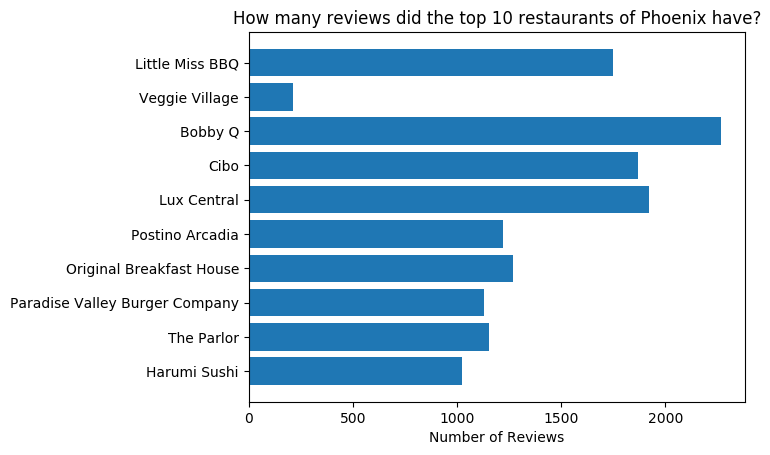

In [12]:
plt.gcf().clear()
fig, ax = plt.subplots()

reviews = np.array(OrderedRestaurants.select('review_count').take(10))

ax.barh(y_pos, reviews)
ax.set_yticks(y_pos)
ax.set_yticklabels(restaurants)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Reviews')
ax.set_title('How many reviews did the top 10 restaurants of Phoenix have?')

plt.show()

Wow, that's something. Now lets see how our ranking is different from the star ratings of these restaurants. We'll take the count of ranks and count of stars in below ranges -

range 1: > 0   & <= 1.5

range 2: > 1.5 & <= 2

range 3: > 2   & <= 2.5

range 4: > 2.5 & <= 3

range 5: > 3   & <= 3.5

range 6: > 3.5 & <= 4

range 7: > 4   & <= 4.5

range 8: > 4.5 & <= 5

In [13]:
rank_range1 = len(rank_df.where((rank_df.ranking > 0) & (rank_df.ranking <= 1.5)).collect())
star_range1 = len(rank_df.where((rank_df.stars > 0) & (rank_df.stars <= 1.5)).collect())
rank_range2 = len(rank_df.where((rank_df.ranking > 1.5) & (rank_df.ranking <= 2)).collect())
star_range2 = len(rank_df.where((rank_df.stars > 1.5) & (rank_df.stars <= 2)).collect())
rank_range3 = len(rank_df.where((rank_df.ranking > 2) & (rank_df.ranking <= 2.5)).collect())
star_range3 = len(rank_df.where((rank_df.stars > 2) & (rank_df.stars <= 2.5)).collect())
rank_range4 = len(rank_df.where((rank_df.ranking > 2.5) & (rank_df.ranking <= 3)).collect())
star_range4 = len(rank_df.where((rank_df.stars > 2.5) & (rank_df.stars <= 3)).collect())
rank_range5 = len(rank_df.where((rank_df.ranking > 3) & (rank_df.ranking <= 3.5)).collect())
star_range5 = len(rank_df.where((rank_df.stars > 3) & (rank_df.stars <= 3.5)).collect())
rank_range6 = len(rank_df.where((rank_df.ranking > 3.5) & (rank_df.ranking <= 4)).collect())
star_range6 = len(rank_df.where((rank_df.stars > 3.5) & (rank_df.stars <= 4)).collect())
rank_range7 = len(rank_df.where((rank_df.ranking > 4) & (rank_df.ranking <= 4.5)).collect())
star_range7 = len(rank_df.where((rank_df.stars > 4) & (rank_df.stars <= 4.5)).collect())
rank_range8 = len(rank_df.where((rank_df.ranking > 4.5) & (rank_df.ranking <= 5)).collect())
star_range8 = len(rank_df.where((rank_df.stars > 4.5) & (rank_df.stars <= 5)).collect())

In [14]:
# rank_range1 #0
# rank_range2 #0
# rank_range3 #0
# rank_range4 #88
# rank_range5 #2407
# rank_range6 #1125
# rank_range7 #222
# rank_range8 #2
# star_range1 #129
# star_range2 #246
# star_range3 #391
# star_range4 #652
# star_range5 #852
# star_range6 #943
# star_range7 #503
# star_range8 #128

Ranks are 0 (zero) for the range 0 - 2.5, and for 4.5 - 5 there are only 2 restaurants. So, we'll not plot for them.

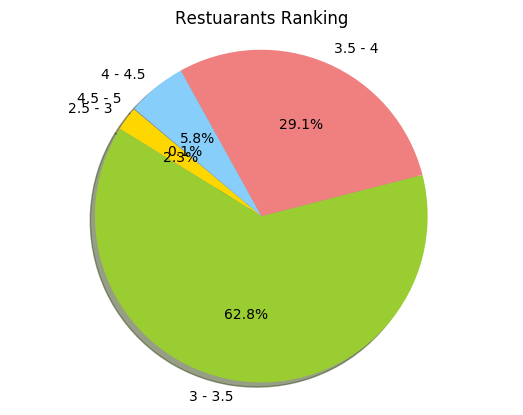

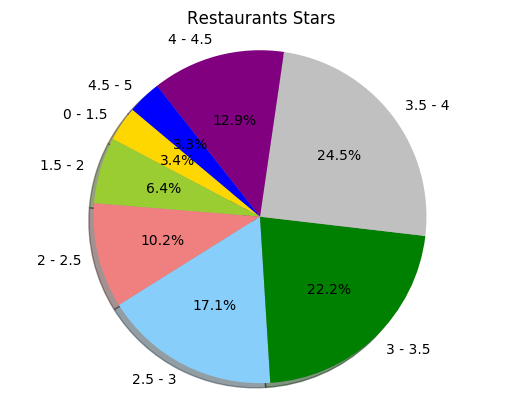

In [15]:
# clear all previous plots
plt.gcf().clear()
# Data to plot
# pie chart of Ranks
labels = '2.5 - 3', '3 - 3.5', '3.5 - 4', '4 - 4.5', '4.5 - 5'
sizes = [rank_range4, rank_range5, rank_range6, rank_range7, rank_range8]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'grey']
#explode = (0, 0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)#explode=explode, 
plt.axis('equal')
plt.title("Restuarants Ranking")
plt.show()

# pie chart of Stars
labels = '0 - 1.5', '1.5 - 2', '2 - 2.5', '2.5 - 3', '3 - 3.5', '3.5 - 4', '4 - 4.5', '4.5 - 5'
sizes = [star_range1, star_range2, star_range3, star_range4, star_range5, star_range6, star_range7, star_range8]# rank_range8]#np.array(cityPhoenix.select('stars').collect())
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'green', 'silver', 'purple', 'blue']
#explode = (0, 0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)#explode=explode, 
plt.axis('equal')
plt.title("Restaurants Stars")
plt.show()

And what does an Overlapping histogram for this ranks and stars look like?

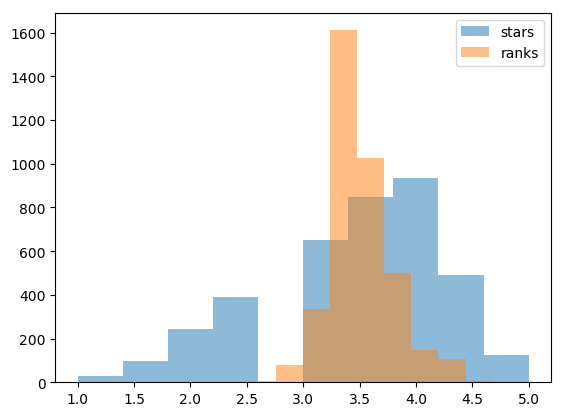

In [16]:
# overlapping histogram
plt.gcf().clear()
x = np.array(rank_df.select('stars').collect())
y = np.array(rank_df.select('ranking').collect())

plt.hist(x, alpha=0.5, label='stars')
plt.hist(y, alpha=0.5, label='ranks') 
plt.legend(loc='upper right')
plt.show()

Let's check the reviews of the top restaurant and create its word cloud. Word Cloud is a graphical representation of the frequency of words in a text.

In [17]:
path = "/user/cloudera/data/yelp_academic_dataset_review.json"
reviewJson = sqlContext.read.json(path)
reviewJson.registerTempTable("reviewTable")

In [18]:
reviewText = sqlContext.sql("SELECT text FROM reviewTable where business_id = 'Xg5qEQiB-7L6kGJ5F4K3bQ'")
review_list = list(reviewText.select('text').toPandas()['text'])

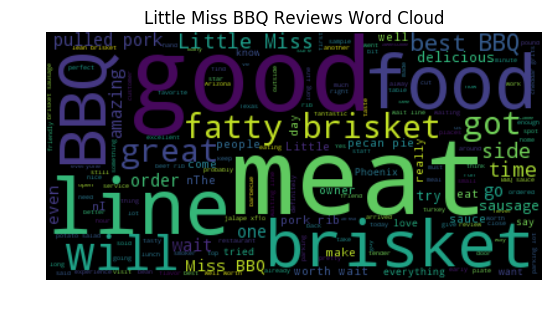

In [19]:
stopwords = set(STOPWORDS)
stopwords.add('place')
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(str(review_list))

# Display the generated image:
plt.gcf().clear()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Little Miss BBQ Reviews Word Cloud")
plt.show()

Let's do a word cloud and see how the reviews are for a not so good restaurant of yelp.

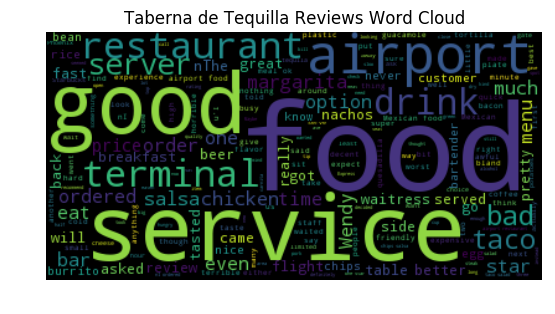

In [20]:
# rank_df.where(rank_df.buisness_id == 'bLRjPq9-pAdXirAWWTuZzg').show()
# +--------------------+-------------------+-------------+-------------+-----------+------------+-----+-------+
# |         business_id|               name|     latitude|    longitude|postal_code|review_count|stars|ranking|
# +--------------------+-------------------+-------------+-------------+-----------+------------+-----+-------+
# |bLRjPq9-pAdXirAWW...|Taberna de Tequilla|33.4366741122|-112.00894289|      85034|         173|  2.0|   2.52|
# +--------------------+-------------------+-------------+-------------+-----------+------------+-----+-------+
reviewText = sqlContext.sql("SELECT text FROM reviewTable where business_id = 'bLRjPq9-pAdXirAWWTuZzg'")
review_list = list(reviewText.select('text').toPandas()['text'])

# Create word cloud for this restaurant
wordcloud = WordCloud(stopwords=stopwords).generate(str(review_list))

# Display the generated image:
plt.gcf().clear()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Taberna de Tequilla Reviews Word Cloud")
plt.show()

In [21]:
#plotting the count of stars of top restaurant and lower restaurant based on star rating against each year
import seaborn as sns
%matplotlib inline
# Setting context for figure aesthetics 
sns.set_context(context="talk")
# Plotting figure size
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

/home/cloudera/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



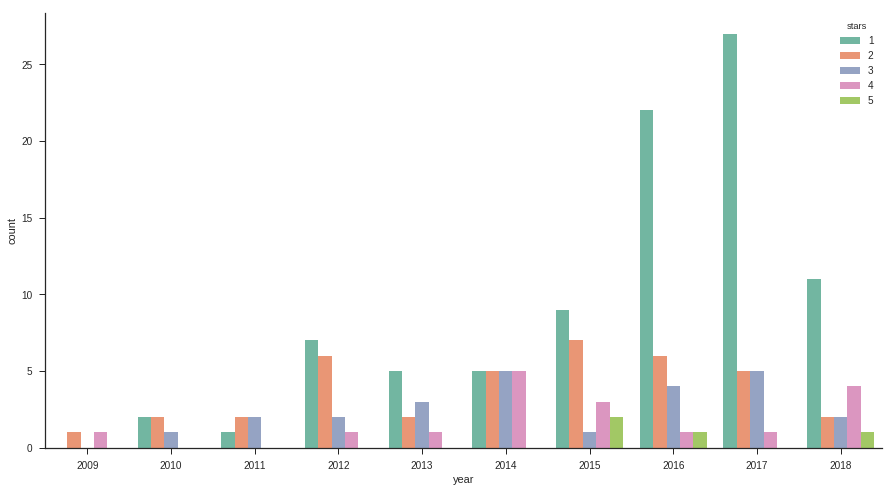

In [22]:
review_df = sqlContext.sql("SELECT business_id, Year(date) as year, stars, text FROM reviewTable WHERE business_id = 'bLRjPq9-pAdXirAWWTuZzg'")
ax = sns.countplot(x='year', data=review_df.toPandas(), hue='stars')
sns.despine()

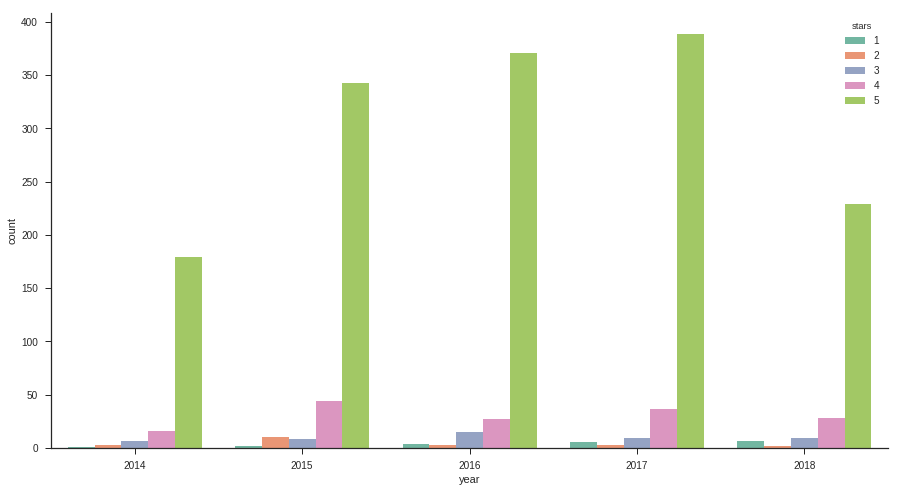

In [23]:
review_df = sqlContext.sql("SELECT business_id, Year(date) as year, stars, text FROM reviewTable WHERE business_id = 'Xg5qEQiB-7L6kGJ5F4K3bQ'")
ax = sns.countplot(x='year', data=review_df.toPandas(), hue='stars')
sns.despine()

In [24]:
reviewPhoenix = sqlContext.sql("SELECT reviewTable.* from reviewTable INNER JOIN businessTable on reviewTable.business_id = businessTable.business_id where businessTable.city in ('Phx', 'Phoenix Valley', 'Pheonix', 'Pheonix AZ', 'Phoenix' ) and businessTable.categories like '%Restaurant%'")

In [25]:
import pandas as pd
review_dataframe = reviewPhoenix.toPandas()
review_dataframe = review_dataframe.set_index('review_id')

/home/cloudera/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



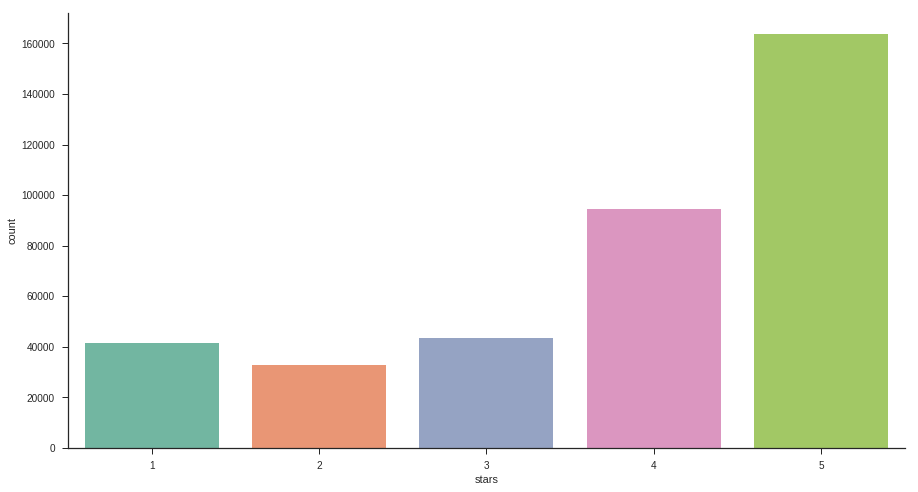

In [27]:
#plotting the count of restaurants for each star rating in Phoenix 
ax = sns.countplot(x='stars', data=review_dataframe)
# Removing spines
sns.despine()

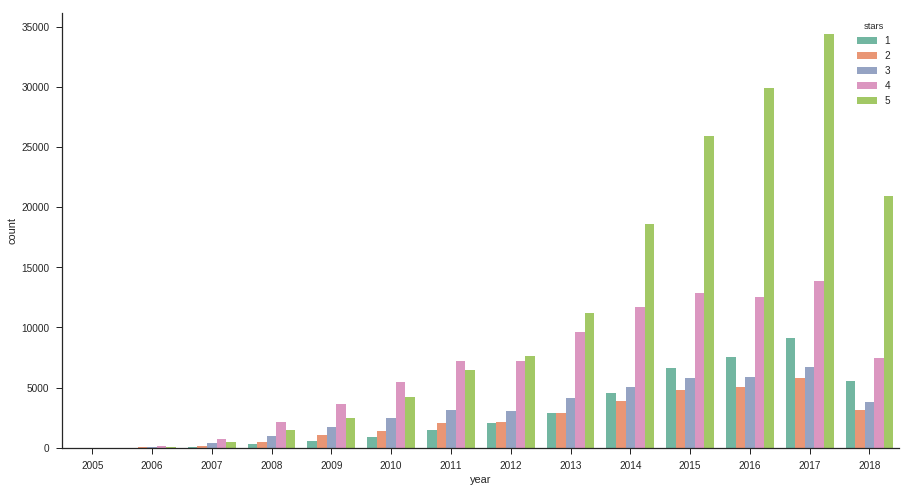

In [28]:
#plotting the count of restaurants based on star rating against each year
review_dataframe['datetime'] = pd.to_datetime(review_dataframe['date'])
review_dataframe['year'] = review_dataframe['datetime'].dt.year
ax = sns.countplot(x='year', data=review_dataframe, hue='stars')
sns.despine()

In [29]:
review_dataframe.columns

Index([u'business_id', u'cool', u'date', u'funny', u'stars', u'text',
       u'useful', u'user_id', u'datetime', u'year'],
      dtype='object')

In [30]:
#creating function for converting date string into  time difference
def calculate_date_difference(df, start_date, end_date):
    datetime = pd.to_datetime(df[start_date])
    time_diff = datetime.max() - datetime
    df[end_date] = time_diff.apply(lambda x: x.days)
    df.drop(start_date, axis=1, inplace=True)

In [31]:
#Converting strings to categorical values
def to_length(df, start_col, end_col):
    df[end_col] = df[start_col].apply(lambda x: len(x))
    df.drop(start_col, axis=1, inplace=True)

In [32]:
#function to delete unnecessary columns
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [33]:
#function to drop columns
def to_boolean(df, cols):
    for column in cols:
        to_column = column+'_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [34]:
#filling null values with a standard value
FILL_WITH = 0.0

In [35]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # adding FILL_WITH category for fillna() to work w/o error
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        #print 'categories for ', column, ' include ', df[column].cat.categories

In [36]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        #print 'column ', column, ' has ', size, ' columns, include ', df[column].cat.categories
        df[column] = df[column].cat.rename_categories(range(1, size+1))
        #print 'becomes ', df[column].cat.categories

In [37]:
calculate_date_difference(df=review_dataframe, start_date='date', end_date='date_delta')
to_length(df=review_dataframe, start_col='text', end_col='text_len')
drop_columns(df=review_dataframe, columns=['year', 'datetime'])
review_dataframe.fillna(value=0.0, inplace=True)

In [38]:
# target y is whether a review is five-star
y = review_dataframe.stars.apply(lambda x: x == 5)

#dropped non-related earlier from data X
X = review_dataframe
review_dataframe.drop('stars', axis=1, inplace=True)
# getting the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

In [39]:
from sklearn.cross_validation import train_test_split

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

/home/cloudera/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [40]:
print 'training data shape', X_train.shape
print 'test data shape', X_test.shape
print 'converted label data shape', y_train.shape
#print 'features', features

training data shape (282250, 7)
test data shape (94084, 7)
converted label data shape (282250,)


In [41]:
#converting the data into incremental numerical values in training dataset
from sklearn import preprocessing
le= preprocessing.LabelEncoder()
for column_name in X_train.columns:
    if X_train[column_name].dtype==object:
        X_train[column_name]=le.fit_transform(X_train[column_name])
    else:
        pass

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [42]:
#converting the data into incremental numerical values in test dataset
from sklearn import preprocessing
le= preprocessing.LabelEncoder()
for column_name in X_test.columns:
    if X_test[column_name].dtype==object:
        X_test[column_name]=le.fit_transform(X_test[column_name])
    else:
        pass

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [43]:
#preprocessing the datasets
from sklearn import preprocessing

# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
from sklearn.cross_validation import cross_val_score
import numpy as np

# Function used to print cross-validation scores
def training_score(est, X, y, cv):
    acc = cross_val_score(est, X, y, cv = cv, scoring='accuracy')
    roc = cross_val_score(est, X, y, cv = cv, scoring='roc_auc')
    print '5-fold Train CV | Accuracy:', round(np.mean(acc), 3),'+/-', \
    round(np.std(acc), 3),'| ROC AUC:', round(np.mean(roc), 3), '+/-', round(np.std(roc), 3)

In [45]:
from sklearn import linear_model

# Building logistic regression model using default parameter values
lrc = linear_model.LogisticRegression()

In [46]:
from sklearn.cross_validation import StratifiedKFold

# cross-validation 
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True)

In [47]:
# printing cross-validation scores
training_score(est=lrc, X=X_train_scaled, y=y_train, cv=cv)

5-fold Train CV | Accuracy: 0.625 +/- 0.001 | ROC AUC: 0.659 +/- 0.002


In [48]:
# Computing confusion matrix
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Running classifier
lrc_fit = lrc.fit(X_train_scaled, y_train)
y_pred = lrc_fit.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[ 0.74305843  0.25694157]
 [ 0.53231018  0.46768982]]


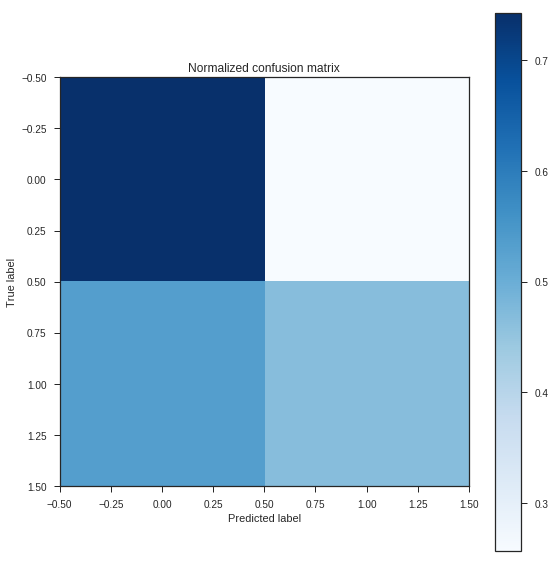

In [49]:
# Normalizing the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

In [51]:
#plotting the most popular cuisines in the state of Phoenix
import pandas as pd

PATH = '/home/cloudera/Downloads/'
cuisine_dataframe = pd.read_csv(PATH + 'Phoenix Restaurants.csv')

In [52]:
cuisine_dataframe = cuisine_dataframe.set_index('business_id')
cuisine_dataframe.columns

Index([u'Serial Number', u'address', u'attributes', u'Category 1',
       u'Category 2', u'Category 3', u'Event Planning & Caterers', u'Cuisine',
       u'Cuisine 2', u'Cuisine 3', u'Cuisine 4', u'Cuisine5', u'Cuisine6',
       u'Cuisine Type 1', u'city', u'hours', u'is_open', u'latitude',
       u'longitude', u'name', u'neighborhood', u'postal_code', u'review_count',
       u'stars', u'state'],
      dtype='object')

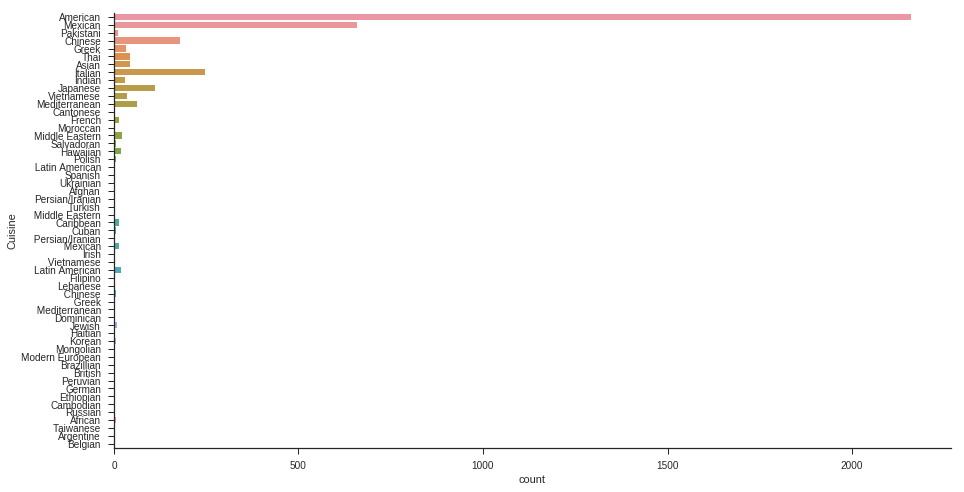

In [53]:
#plotting the most popular cuisines with their count in the state of Phoenix
axis = sns.countplot(y='Cuisine', data=cuisine_dataframe)
# Removing spines
sns.despine()

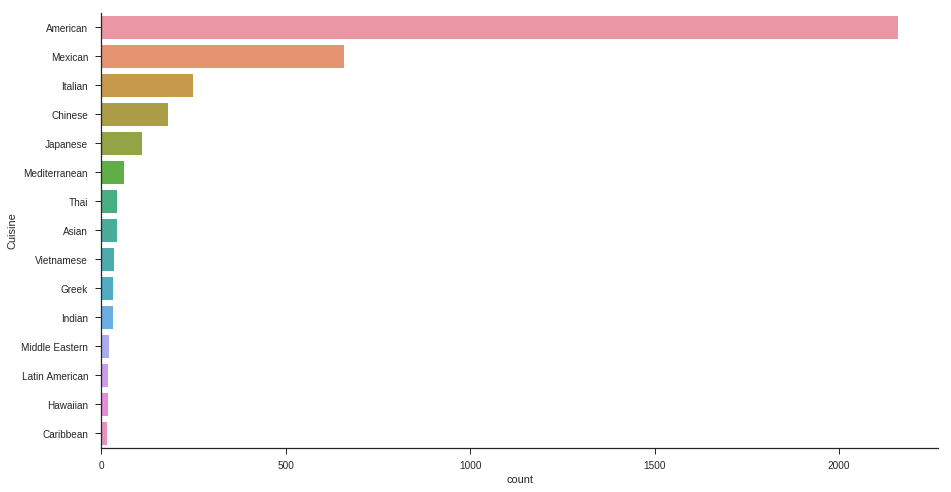

In [54]:
#plotting the Top 15 cuisines with their count in the state of Phoenix
axis = sns.countplot(y='Cuisine', data=cuisine_dataframe, order=cuisine_dataframe.Cuisine.value_counts().iloc[:15].index)
# Removing spines
sns.despine()

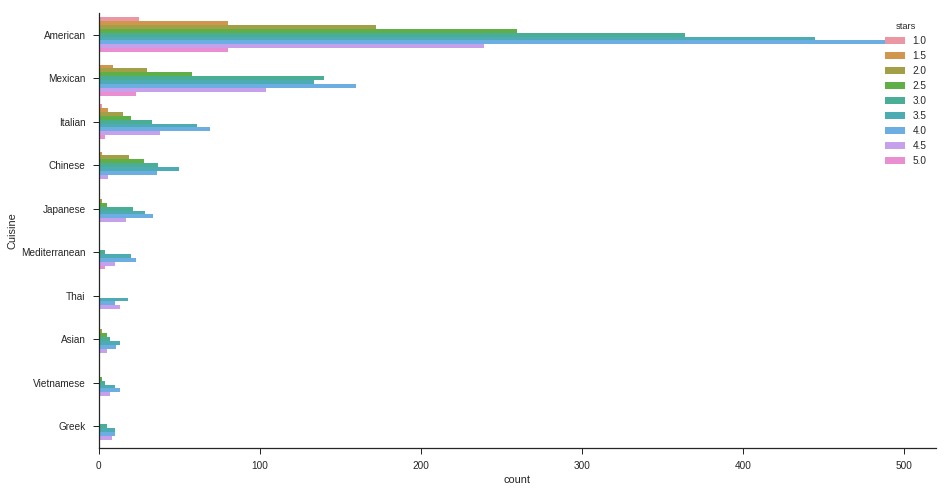

In [55]:
#plotting the Top 15 cuisines with their count as per the star rating in the state of Phoenix
ax = sns.countplot(y='Cuisine', data=cuisine_dataframe, hue='stars',order=cuisine_dataframe.Cuisine.value_counts().iloc[:10].index)
sns.despine()

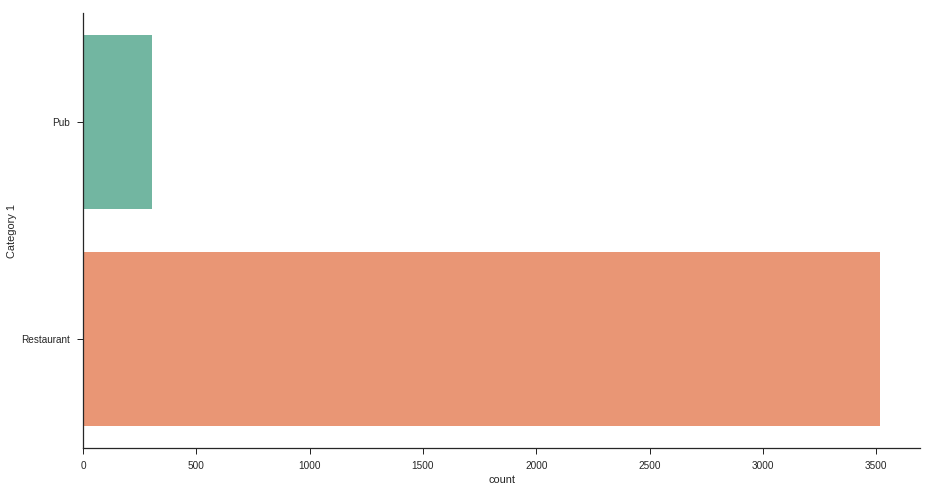

In [56]:
#plotting the number of Pubs and Restaurants in Phoenix
axis = sns.countplot(y='Category 1', data=cuisine_dataframe)
# Removing spines
sns.despine()

In [57]:
#review analysis to predict star rating based on positive and negative review
#but first load the original dataset. I did a lot of tweaks to it above, so now I'm reloading all the columns again.
review_dataframe = reviewPhoenix.toPandas()
review_dataframe = review_dataframe.set_index('review_id')
import nltk
from nltk.corpus import stopwords
review_dataframe.shape

(376334, 8)

In [58]:
review_dataframe.head()

,business_id,cool,date,funny,stars,text,useful,user_id
review_id,,,,,,,,
XMo-1jC_BQg2N0MiOAOXFQ,10Ft6GZPvoZyRWi1bVo3Rw,0,2015-08-01,0,4,"I love this location of Subway, everyone is al...",0,hBrGv46Q0qc1xFdYGqyDyA
88maphSnQUlRJW-j_9pj2g,10Ft6GZPvoZyRWi1bVo3Rw,0,2018-05-29,0,5,I had a beautiful experience at Subway today L...,0,iHOSVrTHXZzNe1mieu4jiA
0Tvt2ZYjnKACfaMTm4h9_Q,10Ft6GZPvoZyRWi1bVo3Rw,0,2017-05-20,0,5,"As frequent Subway eaters, my wife and I have ...",0,3yuNquRhNselqNriMs4-Iw
azfLopm7CfEgzrs7AYf8-w,10Ft6GZPvoZyRWi1bVo3Rw,1,2018-01-16,0,5,Holiday Monday and was not looking to prepare ...,1,s76BDmBx_8kcxGFDiU6k_g
NMjCB2FzH7vppfngZkphcg,10Ft6GZPvoZyRWi1bVo3Rw,0,2018-05-07,0,4,There is nothing wrong with Subway. This locat...,0,ZOToYJhEZiGsSnfD--uNMw


In [59]:
review_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 376334 entries, XMo-1jC_BQg2N0MiOAOXFQ to TlqAG9bSQZR7mH9CZJyhlA
Data columns (total 8 columns):
business_id    376334 non-null object
cool           376334 non-null int64
date           376334 non-null object
funny          376334 non-null int64
stars          376334 non-null int64
text           376334 non-null object
useful         376334 non-null int64
user_id        376334 non-null object
dtypes: int64(4), object(4)
memory usage: 25.8+ MB


In [60]:
review_dataframe.describe()

,cool,funny,stars,useful
count,376334.000000,376334.000000,376334.000000,376334.000000
mean,0.622609,0.493793,3.813631,1.166227
std,2.316369,1.837649,1.364346,2.883050
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,1.000000,0.000000,5.000000,1.000000
max,205.000000,168.000000,5.000000,212.000000


In [61]:
review_dataframe.columns

Index([u'business_id', u'cool', u'date', u'funny', u'stars', u'text',
       u'useful', u'user_id'],
      dtype='object')

In [62]:
#calculating length of each review text
review_dataframe['text length'] = review_dataframe['text'].apply(len)
review_dataframe.head()

,business_id,cool,date,funny,stars,text,useful,user_id,text length
review_id,,,,,,,,,
XMo-1jC_BQg2N0MiOAOXFQ,10Ft6GZPvoZyRWi1bVo3Rw,0,2015-08-01,0,4,"I love this location of Subway, everyone is al...",0,hBrGv46Q0qc1xFdYGqyDyA,106
88maphSnQUlRJW-j_9pj2g,10Ft6GZPvoZyRWi1bVo3Rw,0,2018-05-29,0,5,I had a beautiful experience at Subway today L...,0,iHOSVrTHXZzNe1mieu4jiA,467
0Tvt2ZYjnKACfaMTm4h9_Q,10Ft6GZPvoZyRWi1bVo3Rw,0,2017-05-20,0,5,"As frequent Subway eaters, my wife and I have ...",0,3yuNquRhNselqNriMs4-Iw,869
azfLopm7CfEgzrs7AYf8-w,10Ft6GZPvoZyRWi1bVo3Rw,1,2018-01-16,0,5,Holiday Monday and was not looking to prepare ...,1,s76BDmBx_8kcxGFDiU6k_g,502
NMjCB2FzH7vppfngZkphcg,10Ft6GZPvoZyRWi1bVo3Rw,0,2018-05-07,0,4,There is nothing wrong with Subway. This locat...,0,ZOToYJhEZiGsSnfD--uNMw,113


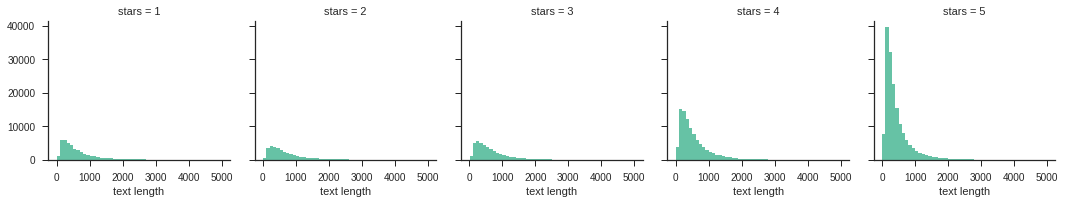

In [63]:
#using FacetGrid to see if there’s any relationship between new columns text length and the stars rating.
g = sns.FacetGrid(data=review_dataframe, col='stars')
g.map(plt.hist, 'text length', bins=50)

the distribution of text length is similar across all five ratings. However, the number of text reviews seems to be skewed a lot higher towards the 4-star and 5-star ratings

/home/cloudera/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



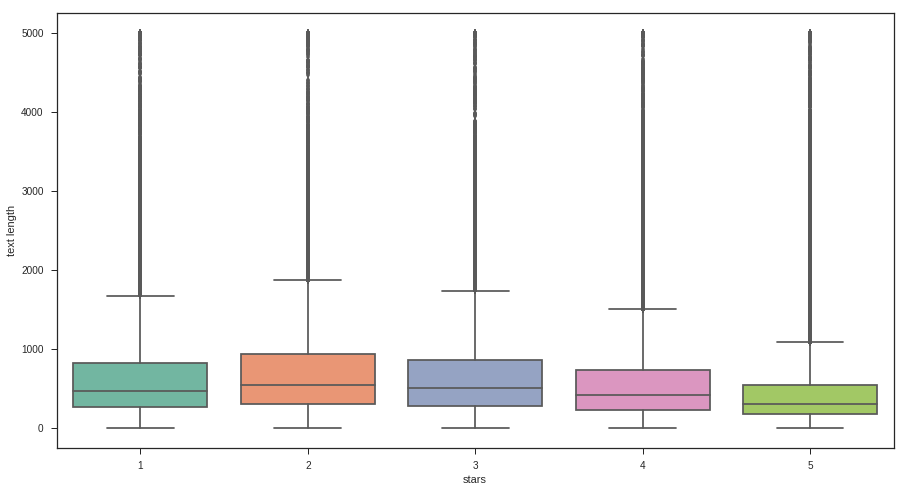

In [64]:
#boxplot of each star rating
sns.boxplot(x='stars', y='text length', data=review_dataframe)

From the plot, it is visible that the 1-star and 2-star ratings have much longer text, but there are many outliers which are visible above the boxes. Because of this, maybe text length won’t be such a useful feature to consider after all.

In [65]:
#grouping the data by the star rating, and see if we can find a correlation between features such as cool, useful, and funny
stars = review_dataframe.groupby('stars').mean()
stars.corr()

,cool,funny,useful,text length
cool,1.000000,-0.322048,-0.359394,-0.372494
funny,-0.322048,1.000000,0.988316,0.939528
useful,-0.359394,0.988316,1.000000,0.933283
text length,-0.372494,0.939528,0.933283,1.000000


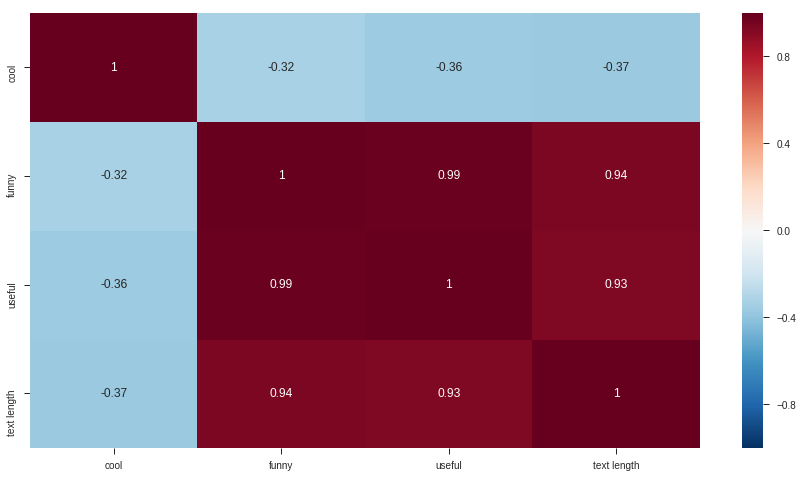

In [66]:
#visualizing the correlations
sns.heatmap(data=stars.corr(), annot=True)

In [67]:
#Looking at the map, funny is strongly correlated with useful, and useful seems strongly correlated with text length. We can also see a negative correlation between cool and the other three features.
#Predicting if the review is bad or good, For that, fetching reviews which have rating value either 1 or 5 stars from the dataframe. Storing the resulting reviews in a new dataframe called review_class.
review_class = review_dataframe[(review_dataframe['stars'] == 1) | (review_dataframe['stars'] == 5)]
review_class.shape

(205570, 9)

In [68]:
X = review_class['text']
y = review_class['stars']

In [69]:
X[0]

u'I had a beautiful experience at Subway today Lief and Miguel were very nice. Lief made a great sandwich and suggested that I toast my onions and my bell peppers and boy was he right. My sandwich taste delicious and I will definitely be getting it this way all the time. The both of them are two wonderful amazing young men who are definitely a great representative for Subway. Put smiles on not just my face but other customers as well. Thanks guys for being so kind.'

In [70]:
#downloading the stopwords of nltk to remove the same from review text and to fetch individual words.
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cloudera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
#Converting the statements into individual words
#Removing Punctuation
#Removing Stopwords
#Returning Clean text
import string

def text_process(text):

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [72]:
#Testing the function with random text
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."
print(text_process(sample_text))

['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


In [73]:
print('Shape of Sparse Matrix: ', X.shape)
#print('Amount of Non-Zero occurrences: ', X.nnz)

('Shape of Sparse Matrix: ', (205570,))


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [75]:
print 'training data shape', X_train.shape
print 'test data shape', X_test.shape
print 'converted label data shape', y_train.shape
#print 'features', features

training data shape (143899,)
test data shape (61671,)
converted label data shape (143899,)


In [ ]:
#vectorizating initiation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [ ]:
X = bow_transformer.transform(X)

In [ ]:
#dividing the data into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
#Running the model on training dataset
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

In [ ]:
#prediction model 
preds = nb.predict(X_test)

In [ ]:
positive_review = review_class['text'][198]
positive_review

In [ ]:
negative_review = review_class['text'][76]
negative_review

In [ ]:
#running the prediction model on a negative review to predict the rating of the same
negative_review_transformed = bow_transformer.transform([negative_review])

nb.predict(negative_review_transformed)[0]

# Pre -Processing Data - get data ready for modelling

Creation of data for modelling (numeric columns) 
Independent variable - longitude, latitude, review_count
Dependent variable -stars
Goal: The variance of the stars with the change in latitude, longitude and review_count variables.

In [76]:
cityPhoenix.registerTempTable("phoenixTable")
ModelData = sqlContext.sql("Select stars,longitude, latitude, review_count from phoenixTable")
ModelData=ModelData.select('stars','longitude','latitude','review_count')
#ModelData.show(5)

In [77]:
ModelData.toPandas().head()

,stars,longitude,latitude,review_count
0,4.0,-112.091188,33.479807,277
1,2.5,-112.236076,33.495298,3
2,2.5,-112.225173,33.479671,14
3,2.0,-112.235798,33.495422,4
4,3.5,-112.087738,33.639774,230


In [78]:
ModelData.describe(['stars','longitude', 'latitude', 'review_count']).show()

+-------+------------------+-------------------+------------------+------------------+
|summary|             stars|          longitude|          latitude|      review_count|
+-------+------------------+-------------------+------------------+------------------+
|  count|              3817|               3817|              3817|              3817|
|   mean|3.4453759496987164|-112.06404281673487|33.500452590347436| 98.38826303379618|
| stddev|0.8393432476635345|0.06546075639483709|1.0893623011339844|179.34843682320928|
|    min|               1.0|       -112.5721881|         -33.50857|                 3|
|    max|               5.0|        -111.790112|        33.8740033|              2267|
+-------+------------------+-------------------+------------------+------------------+



# Pre Analysis -Before Modelling

Initial preparations for the creating a model. 
Modelling: Linear regression model.
Input needed: Labelled point 

Pre Analaysis: 
1) Perform the correlation between the variables to be modelled
2) Check for the distribution of the data - box plot and scatter plot
3) Histogram to check for the distribution of data

In [79]:
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import * 

In [80]:
temp = ModelData.map(lambda line: LabeledPoint(line[0],[line[1:]]))
temp.take(5)

[LabeledPoint(4.0, [-112.0911877,33.4798071,277.0]),
 LabeledPoint(2.5, [-112.2360764,33.4952976,3.0]),
 LabeledPoint(2.5, [-112.2251729,33.4796712,14.0]),
 LabeledPoint(2.0, [-112.235797843,33.4954215852,4.0]),
 LabeledPoint(3.5, [-112.0877381,33.6397742,230.0])]

In [81]:
temp

PythonRDD[318] at RDD at PythonRDD.scala:43

Perform statistical operations on the data to be modelled

In [82]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors, Matrices
from pyspark.mllib.feature import StandardScaler
ModelDataPipelined = ModelData.map(lambda row: row(float(row[0]),float(row[1]),float(row[2]),float(row[3])))
ModelData.take(1)

[Row(stars=4.0, longitude=-112.0911877, latitude=33.4798071, review_count=277)]

In [83]:
from pyspark.mllib.linalg import DenseVector
features = ModelData.map(lambda row: row[1:])
Correlationfeature = ModelData.map(lambda row: row[0:])
features.take(1)

[(-112.0911877, 33.4798071, 277)]

The below code snippet calculates the mean and variance of the vectors. The output shows the distribution of the data and the number of zeros in the data, we see that there are no zeros in the data.

In [84]:
from pyspark.mllib.stat import Statistics

summary = Statistics.colStats(Correlationfeature)
print(summary.mean())
print(summary.variance())
print(summary.numNonzeros())

[   3.44537595 -112.06404282   33.50045259   98.38826303]
[  7.04497087e-01   4.28511063e-03   1.18671022e+00   3.21658618e+04]
[ 3817.  3817.  3817.  3817.]


Checking for correlation of the columns to be able to run a regression model. Now that the plot gives an output that the independent variables are not correlated

In [85]:
data =features # an RDD of Vectors
# calculate the correlation matrix using Pearson's method. Use "spearman" for Spearman's method.
# If a method is not specified, Pearson's method will be used by default. 
print(Statistics.corr(data, method="pearson"))

[[ 1.         -0.01586011  0.11491688]
 [-0.01586011  1.          0.00412678]
 [ 0.11491688  0.00412678  1.        ]]


Convert the RDD of data into lists and arrays to be able to plot the variables to be able to understand the distribution of data

In [86]:
result = sqlContext.sql("Select review_count from phoenixTable")
result_array = result.rdd.map(lambda row: row.review_count).sample(False,0.1).collect()
#result_array

In [87]:
result

DataFrame[review_count: bigint]

Plot a BoxPlot on review_count column to see if any outliers exist. From the plot, we find that they are many outliers.

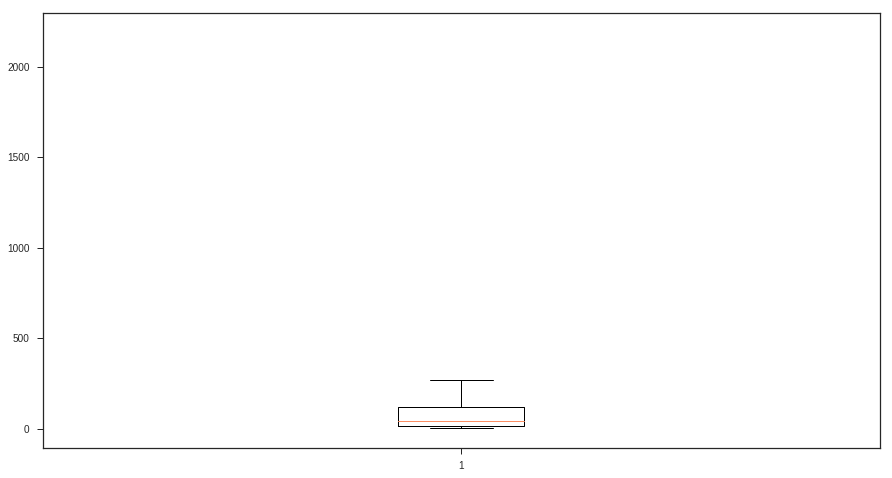

In [88]:
import matplotlib.pyplot as plt

plt.boxplot(result_array)
plt.show()

Converting data in a DataFrame into a list to run the necessary plots

In [89]:
datatoModel = ModelData
data_array =datatoModel.rdd.sample(False,0.1).map(lambda row: (row.stars, row.longitude,row.latitude,row.review_count))
data_array_stars = data_array.map(lambda (stars, longitude, latitude, review_count): stars ).collect()
data_array_longitude = data_array.map(lambda (stars, longitude, latitude, review_count): longitude ).collect()
data_array_latitude = data_array.map(lambda (stars, longitude, latitude, review_count): latitude ).collect()
data_array_reviewCount = data_array.map(lambda (stars, longitude, latitude, review_count): review_count ).collect()


Plot a scatter plot between the stars and review_count to interpret if any relation between the star rating and the review_count

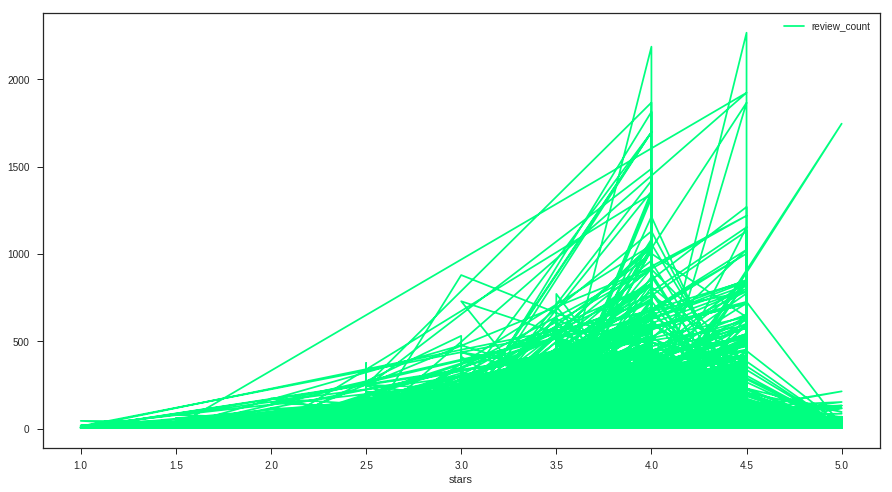

In [90]:
from IPython.display import display 

plots = ModelData.toPandas()
plots.plot(x='stars', y ='review_count',colormap='winter_r')
plt.show()

In [91]:
standardizer = StandardScaler()
model = standardizer.fit(features)
features_transform = model.transform(features)

In [92]:
features_transform.take(5)

[DenseVector([-1712.3418, 30.7334, 1.5445]),
 DenseVector([-1714.5551, 30.7476, 0.0167]),
 DenseVector([-1714.3886, 30.7333, 0.0781]),
 DenseVector([-1714.5509, 30.7477, 0.0223]),
 DenseVector([-1712.2891, 30.8802, 1.2824])]

In [93]:
labels = ModelData.map(lambda row: row[0])
labels.take(5)

[4.0, 2.5, 2.5, 2.0, 3.5]

In [94]:
transformedData = labels.zip(features_transform)
transformedData.take(5)

[(4.0, DenseVector([-1712.3418, 30.7334, 1.5445])),
 (2.5, DenseVector([-1714.5551, 30.7476, 0.0167])),
 (2.5, DenseVector([-1714.3886, 30.7333, 0.0781])),
 (2.0, DenseVector([-1714.5509, 30.7477, 0.0223])),
 (3.5, DenseVector([-1712.2891, 30.8802, 1.2824]))]

In [95]:
transformedData = transformedData.map(lambda row : LabeledPoint(row[0],row[1]))
transformedData.take(5)

[LabeledPoint(4.0, [-1712.3417735,30.7333997745,1.54447958904]),
 LabeledPoint(2.5, [-1714.55514084,30.7476195616,0.0167272157658]),
 LabeledPoint(2.5, [-1714.38857539,30.7332750226,0.0780603402404]),
 LabeledPoint(2.0, [-1714.55088551,30.7477333761,0.0223029543544]),
 LabeledPoint(3.5, [-1712.28907628,30.8802444926,1.28241987538])]

# Linear Regression Model

In [96]:
splits =transformedData.randomSplit([.8,.2],seed=10)
trainingData = splits[0]
testingData = splits[1]
trainingData

PythonRDD[359] at RDD at PythonRDD.scala:43

In [97]:
trainingData.take(5)

[LabeledPoint(4.0, [-1712.3417735,30.7333997745,1.54447958904]),
 LabeledPoint(2.0, [-1714.55088551,30.7477333761,0.0223029543544]),
 LabeledPoint(3.5, [-1710.68712718,30.5869330757,0.156120680481]),
 LabeledPoint(4.5, [-1712.31950673,30.7128198444,0.652361414866]),
 LabeledPoint(5.0, [-1712.02150223,30.7060076938,0.0167272157658])]

In [111]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LinearRegressionModel

linearModel = LinearRegressionWithSGD.train(trainingData,10,.2)

In [112]:
linearModeltest = LinearRegressionWithSGD.train(testingData,10,.2)

In [113]:
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

In [114]:
predAndLabel = trainingData.map(lambda p: (float(linearModel.predict(p.features)),p.label)).cache()
predAndLabel.take(1)

[(-8.678504113008162e+54, 4.0)]

In [115]:
MSE = predAndLabel.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / predAndLabel.count()
print("Mean Squared Error = " + str(MSE))
print "Model coefficients:", str(linearModel)

Mean Squared Error = 7.52795614565e+109
Model coefficients: (weights=[5.0665731466e+51,-9.10014856309e+49,-1.60607143865e+48], intercept=0.0)


In [116]:
metrics = RegressionMetrics(predAndLabel)
#squared error
print("MSE = %s" % metrics.meanSquaredError)
#squared error
print("RMSE = %s" % metrics.rootMeanSquaredError)
#r-squared
print("R-squared = %s " % metrics.r2)
#Mean absolute error
print("MAE = %s" %metrics.meanAbsoluteError)
#explained variance
print("Explained Variance =%s" %metrics.explainedVariance)

MSE = 7.52795614565e+109
RMSE = 8.67637951317e+54
R-squared = -1.06773584748e+110 
MAE = 8.67637803593e+54
Explained Variance =7.52795614565e+109


In [117]:
predAndLabelTest = testingData.map(lambda p: (float(linearModeltest.predict(p.features)),p.label)).cache()
predAndLabelTest.take(1)

[(-8.731409298415098e+54, 2.5)]

In [118]:
MSETest = predAndLabelTest.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / predAndLabelTest.count()
print("Mean Squared Error Test = " + str(MSETest))
print "Model coefficients Test:", str(linearModeltest)

Mean Squared Error Test = 7.60059479535e+109
Model coefficients Test: (weights=[5.0908807652e+51,-9.15024504894e+49,-1.70387628089e+48], intercept=0.0)


In [119]:
metricsTest = RegressionMetrics(predAndLabelTest)
#squared error
print("MSETest = %s" % metricsTest.meanSquaredError)
#squared error
print("RMSETest = %s" % metricsTest.rootMeanSquaredError)
#r-squared
print("R-squaredTest = %s " % metricsTest.r2)
#Mean absolute error
print("MAETest = %s" %metricsTest.meanAbsoluteError)
#explained variance
print("Explained Variance Test =%s" %metricsTest.explainedVariance)

MSETest = 7.60059479535e+109
RMSETest = 8.71813901893e+54
R-squaredTest = -1.08412638342e+110 
MAETest = 8.71813752037e+54
Explained Variance Test =7.60059479535e+109


Hypothesis Testing (Pearson's chi-squared) This is a powerful tool in statistics whether a result is statistically significant, whether this result occurred by chance or not. This tells the goodness of fit and indepedence of data

In [120]:
from pyspark.mllib.linalg import Vectors,Matrices

observed =transformedData
pearson = Statistics.chiSqTest(observed)
print(pearson[0].statistic), pearson[0].pValue, pearson[0].nullHypothesis
print(pearson[1].statistic), pearson[1].pValue, pearson[1].nullHypothesis
print(pearson[2].statistic), pearson[2].pValue, pearson[2].nullHypothesis

27556.0308189 0.0148672113952 the occurrence of the outcomes is statistically independent.
27754.8081267 0.0252552519539 the occurrence of the outcomes is statistically independent.
3063.82030441 1.0 the occurrence of the outcomes is statistically independent.
